# Project: Soccer Dataset 


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#Q1">Question 1:What is the relationship between the age of player and their counts of goal?</a></li>
<li><a href="#Q2">Question 2:Are there some rush time of goal during regular 90 minutes?</a></li>
<li><a href="#Q3">Question 3:Is there any formation which have victory to another formation in high probability?</a></li>
</ul>

<a id='intro'></a>
## Introduction
###         Soccer is my favorite game, I am going to analyse the database of soccer. I did browse the sqlite database by "DB Browser for SQLite", I think the table "match" is most complicated table, there are too many information I need to explore. Further on,  more information were recorded by XML and stored in columns such as "goal", "shoton", and so on.
###         After I parsed XML text, I try to understand the information, but I don't have enough introduction to explan them, so I just carefully pick up some information I could understand literally. 
###         For example, "elapsed","elapsed_plus" should be the time of goal or other event occur. And "player1","player2", should be the player who performed shot or other action.
###         So according to the information I explored, there are 3 questions I interest:
###         1.What is the relationship between the age of player and their counts of goal?
###         2.Are there some rush time of goal during regular 90 minutes?
###         3.Is there any formation which have victory to another formation in high probability?
***

### Import package

In [1]:
import time
start_time = time.time()# You need around 1-2 minutes to run all code.

from sqlalchemy import create_engine
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from collections import Counter
from statsmodels.stats.proportion import proportions_ztest



### Define some function what I use for parse XML or string

In [2]:
def xml2df(xml_data):
    root = ET.XML(xml_data) # element tree
    all_records = []
    for child in root:
        record = {}
        for subchild in child:
            if subchild.text == None:
                subrecord = []
                for grandchild in subchild:
                    subrecord.append(grandchild.text)
                record[subchild.tag] = subrecord
            else:
                record[subchild.tag] = subchild.text
        all_records.append(record)
    df = pd.DataFrame(all_records)
    return df
#To Parse xml to DataFrame. Code Reference: XML TO DataFrame https://gist.github.com/mattmc3/712f280ec81044ec7bd12a6dda560787
#I made some change to fit my dataset.

def goal_age(goal_date,birthday): 
    x = datetime.strptime(goal_date,'%Y-%m-%d %H:%M:%S')
    y = datetime.strptime(birthday,'%Y-%m-%d %H:%M:%S')
    z = x.year - y.year - ((x.month,x.day)<(y.month,y.day))
    return z
#To calculate the age of the player when he shot a goal.

def OnlyNum(s,oth=''):   
    fomart = '0123456789'   
    for c in s:   
        if (c in fomart) == False:   
             s = s.replace(c,'');   
    return s
#change the format of formation form str, this is for parse formation, only numbers show

### Connect database

In [3]:
engine = create_engine('sqlite:///database.sqlite')
con = engine.connect()
#connect sqlite database

***
<a id='Q1'></a>
### Q1: Waht is the relationship between the age of player and their counts of goal?
***

### Data Wrangling
#### 1. I need get data about goal from table "Match", include the match date, player of any goal
#### 2. I also need get player's birthday, so I can calculate the age when they performed the goal
#### 3. And than I will create a DataFrame which include 'player','age','goal counts', every row represent that a player at spesific age had how many goal.
***

In [4]:
#the dataset for question 1: What is the relationship between the age of player and their counts of goal?
rs11 = con.execute('SELECT date,match_api_id,goal FROM Match')
df1 = pd.DataFrame(rs11.fetchall())
df1.columns = rs11.keys()

rs12 = con.execute('SELECT player_api_id,player_name,birthday FROM Player')
df1_player = pd.DataFrame(rs12.fetchall())
df1_player.columns = rs12.keys()

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 3 columns):
date            25979 non-null object
match_api_id    25979 non-null int64
goal            14217 non-null object
dtypes: int64(1), object(2)
memory usage: 609.0+ KB


In [6]:
df1_player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 3 columns):
player_api_id    11060 non-null int64
player_name      11060 non-null object
birthday         11060 non-null object
dtypes: int64(1), object(2)
memory usage: 259.3+ KB


In [7]:
df1.dropna(inplace = True)
#The columns 'goal' have 14217 non-null rows, other rows are null, we can't parse null XML file
#So I have to drop rows with null 'goal' column.
#But we still have 14217 records, it is enough to be a large sample

In [8]:
df1_goal = pd.DataFrame()

for i in df1.index:
    if df1.goal[i].find('player1') != -1:
        df_temp1 = xml2df(df1.goal[i])
        df_temp2 = pd.DataFrame(df_temp1.player1)
        df_temp2['goal_date'] = df1.date[i]
        df_temp2['match_api_id'] = df1.match_api_id[i]
        df1_goal = df1_goal.append(df_temp2,ignore_index = True)
# To parse XML, get each goal player, store in DataFrame df1_goal, columns:
#player1 -------player's id, that is same as player_api_id in player table. this player performed this goal
#goal_date------this is from table Match column 'date',represent the date of the goal
#match_api_id---match id, as a backup index
#row: each row represent a goal
df1_goal.head(20)


,player1,goal_date,match_api_id
0,37799,2008-08-17 00:00:00,489042
1,24148,2008-08-17 00:00:00,489042
2,26181,2008-08-16 00:00:00,489043
3,30853,2008-08-16 00:00:00,489044
4,23139,2008-08-16 00:00:00,489045
5,23139,2008-08-16 00:00:00,489045
6,127857,2008-08-16 00:00:00,489045
7,26165,2008-08-17 00:00:00,489046
8,40198,2008-08-17 00:00:00,489046
9,23264,2008-08-17 00:00:00,489046


In [9]:
df1_goal.info()
# we found 39971 goals, but there a 108 records have no player id
# I need to drop null rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39971 entries, 0 to 39970
Data columns (total 3 columns):
player1         39863 non-null object
goal_date       39971 non-null object
match_api_id    39971 non-null int64
dtypes: int64(1), object(2)
memory usage: 936.9+ KB


In [10]:
df1_goal.dropna(inplace = True)
df1_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39863 entries, 0 to 39970
Data columns (total 3 columns):
player1         39863 non-null object
goal_date       39863 non-null object
match_api_id    39863 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [11]:
df1_goal['player_api_id'] = df1_goal.apply(lambda row: int(row.player1),axis = 1)
#Because the player1 column is a str, I need int to merge to player table.
#So I create a new columns, name'player_api_id',convert str to int
df1_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39863 entries, 0 to 39970
Data columns (total 4 columns):
player1          39863 non-null object
goal_date        39863 non-null object
match_api_id     39863 non-null int64
player_api_id    39863 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [12]:
df1_goal.drop(columns = ['player1'],inplace = True)

In [13]:
df1_goal_player = pd.merge(left = df1_goal, right = df1_player, on = 'player_api_id')
#Merge two DataFrame by player_api_id, I create a new DataFrame df1_goal_player
df1_goal_player.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39665 entries, 0 to 39664
Data columns (total 5 columns):
goal_date        39665 non-null object
match_api_id     39665 non-null int64
player_api_id    39665 non-null int64
player_name      39665 non-null object
birthday         39665 non-null object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [14]:
df1_goal_player['age'] = df1_goal_player.apply(lambda row: goal_age(row.goal_date,row.birthday),axis = 1)
# Acoording to the date of goal ,and player's birthday, I calculate the age when the player performed the goal
df1_goal_player.info()
# There are total 39665 goals

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39665 entries, 0 to 39664
Data columns (total 6 columns):
goal_date        39665 non-null object
match_api_id     39665 non-null int64
player_api_id    39665 non-null int64
player_name      39665 non-null object
birthday         39665 non-null object
age              39665 non-null int64
dtypes: int64(3), object(3)
memory usage: 2.1+ MB


In [15]:
df1_goal_player.head(20)

,goal_date,match_api_id,player_api_id,player_name,birthday,age
0,2008-08-17 00:00:00,489042,37799,Obafemi Martins,1984-10-28 00:00:00,23
1,2008-10-28 00:00:00,489140,37799,Obafemi Martins,1984-10-28 00:00:00,24
2,2008-11-03 00:00:00,489146,37799,Obafemi Martins,1984-10-28 00:00:00,24
3,2008-11-03 00:00:00,489146,37799,Obafemi Martins,1984-10-28 00:00:00,24
4,2008-11-15 00:00:00,489166,37799,Obafemi Martins,1984-10-28 00:00:00,24
5,2008-12-14 00:00:00,489208,37799,Obafemi Martins,1984-10-28 00:00:00,24
6,2009-03-21 00:00:00,489335,37799,Obafemi Martins,1984-10-28 00:00:00,24
7,2009-03-21 00:00:00,489335,37799,Obafemi Martins,1984-10-28 00:00:00,24
8,2009-05-11 00:00:00,489397,37799,Obafemi Martins,1984-10-28 00:00:00,24
9,2009-10-25 00:00:00,674349,37799,Obafemi Martins,1984-10-28 00:00:00,24


In [16]:
df1_player_age_count = df1_goal_player.groupby(['player_api_id','age']).size().reset_index(name='counts')
# Groupby player and age, I count that: at specific age how many goals every player had 
df1_player_age_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341 entries, 0 to 11340
Data columns (total 3 columns):
player_api_id    11341 non-null int64
age              11341 non-null int64
counts           11341 non-null int64
dtypes: int64(3)
memory usage: 265.9 KB


In [17]:
df1_player_age_count.head(20)

,player_api_id,age,counts
0,2752,29,2
1,2752,31,1
2,2752,32,5
3,2768,29,3
4,2802,23,1
5,2802,24,6
6,2802,25,6
7,2802,26,2
8,2802,27,4
9,2802,28,1


In [18]:
df1_player_age_count.nunique()
# I got 4278 players, age range is 24 years, counts of goal range is 1-41

player_api_id    4278
age                24
counts             41
dtype: int64

## Exploratory Data Analysis
### I will use scatter plot the dataset. x axis is age of player, y axis is counts of goal.
***

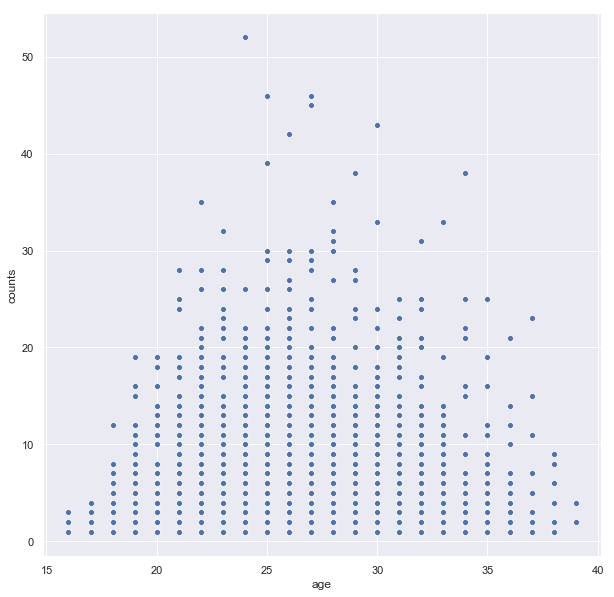

In [19]:
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.scatterplot(x = 'age',y = 'counts',data = df1_player_age_count)

***
## Conclusions

### 1. I have almost 40000 goals records,  the scatter plot shows that overall relationship between age and goal counts has not significant liner regression.
### 2. But if we split in the middle(25-30 years old), we could found a positive liner regression at left plot, and a negative liner regression at right plot.
### 3. That make sence, a 25-30 years old player has peak form during his career. before that his ability is increse, after that his ability is decrease
***

<a id='Q2'></a>
### Q2: Are there some rush time of goal during regular 90 minutes match?
***

## Data Wrangling
### 1. I will find the goal data from the table Match
### 2. And I need to parse XML of goal column
### 3. I will create a DataFrame to store the time when the goal occurred
***

In [20]:
#the dataset for question 2: Are there some rush time of goal during regular 90 minutes?
rs2 = con.execute('SELECT home_team_goal,away_team_goal,goal FROM Match')
df2 = pd.DataFrame(rs2.fetchall())
df2.columns = rs2.keys()

In [21]:
df2.info()
#there are 14217 row have goal record, so I need to drop other rows which not include goal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 3 columns):
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
goal              14217 non-null object
dtypes: int64(2), object(1)
memory usage: 609.0+ KB


In [22]:
df2.dropna(inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14217 entries, 1728 to 25948
Data columns (total 3 columns):
home_team_goal    14217 non-null int64
away_team_goal    14217 non-null int64
goal              14217 non-null object
dtypes: int64(2), object(1)
memory usage: 444.3+ KB


In [23]:
df2_elapsed = pd.DataFrame(columns = ['elapsed','elapsed_plus']) # create a df to store the elapsed for each goal

for i in df2.index:
    if df2.goal[i].find('elapsed') != -1:
        goal_match_i = df2.home_team_goal[i] + df2.away_team_goal[i] # Number of goals scored in this game of both team

        df_temp1 = xml2df(df2.goal[i])
        df_temp2 = pd.DataFrame(df_temp1.elapsed) # extract elapsed for each goal
        
        if 'elapsed_plus' in df_temp1.columns.values: # if this match has goal in extra time, there is a column elapsed_plus
            df_temp2['elapsed_plus'] = df_temp1['elapsed_plus']
        else:
            df_temp2['elapsed_plus'] = np.nan
            
        if goal_match_i == len(df_temp2):  
            # sometimes the number of goal in match i are not equal XML goal record, I think this is data entry mistake, I dont count it.
            df2_elapsed = df2_elapsed.append(df_temp2, ignore_index = True, sort = False)

In [24]:
df2_elapsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35090 entries, 0 to 35089
Data columns (total 2 columns):
elapsed         35090 non-null object
elapsed_plus    1360 non-null object
dtypes: object(2)
memory usage: 548.4+ KB


In [25]:
df2_elapsed.fillna(0,inplace = True)

In [26]:
df2_elapsed.head(20)

,elapsed,elapsed_plus
0,22,0
1,24,0
2,4,0
3,83,0
4,4,0
5,10,0
6,47,0
7,47,0
8,64,0
9,69,0


In [27]:
df2_elapsed.elapsed.unique()
# there are 90 unique time, that make sence, the goal could occurr in every minute

array(['22', '24', '4', '83', '10', '47', '64', '69', '74', '76', '90',
       '45', '65', '67', '34', '41', '9', '23', '82', '12', '26', '89',
       '14', '30', '13', '37', '46', '68', '53', '3', '50', '75', '73',
       '87', '42', '11', '60', '21', '77', '88', '55', '62', '27', '51',
       '43', '63', '85', '16', '29', '40', '57', '66', '49', '84', '8',
       '80', '71', '33', '70', '81', '38', '20', '78', '56', '54', '79',
       '61', '31', '59', '1', '6', '39', '58', '32', '17', '25', '86',
       '52', '18', '15', '28', '36', '72', '44', '19', '2', '7', '5',
       '35', '48'], dtype=object)

In [28]:
df2_elapsed['time'] = df2_elapsed.apply(lambda row: int(row.elapsed),axis = 1)
df2_elapsed['time_plus'] = df2_elapsed.apply(lambda row: int(row.elapsed_plus),axis = 1)
#conver str to int to create the new columns time,time_plus, that are same meaning

In [29]:
df2_elapsed.drop(columns = ['elapsed','elapsed_plus'],inplace = True)
df2_elapsed.head(20)

,time,time_plus
0,22,0
1,24,0
2,4,0
3,83,0
4,4,0
5,10,0
6,47,0
7,47,0
8,64,0
9,69,0


In [30]:
df2_firsthalf = df2_elapsed.loc[df2_elapsed['time']<=45]
df2_secondhalf = df2_elapsed.loc[df2_elapsed['time']>45]
#split all dataset half-half, because every match has first half and second half

In [31]:
for index,row in df2_firsthalf.iterrows():
    row['time'] += row['time_plus']
for index,row in df2_secondhalf.iterrows():
    row['time'] += row['time_plus']

## Exploratory Data Analysis
### I will plot histogram for df2_firsthalf and df2_secondhalf, let's look at what time is the rush time.
***

In [32]:
firsthalf_bin = df2_firsthalf.nunique().time
secondhalf_bin = df2_secondhalf.nunique().time

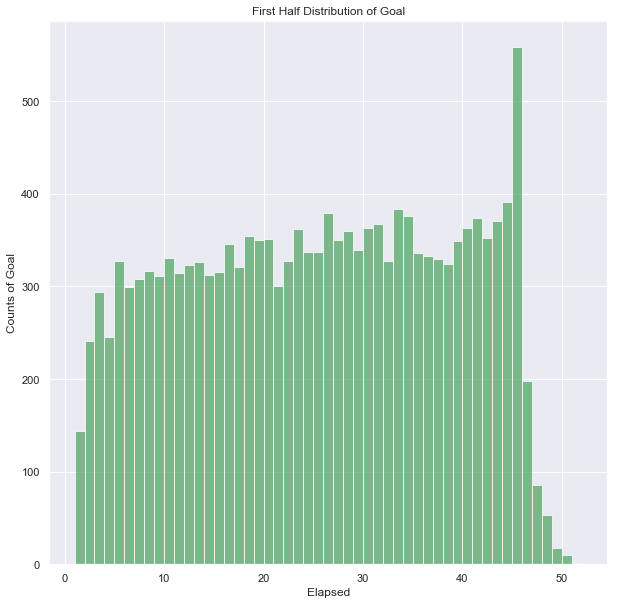

In [33]:
plt.xlabel('Elapsed')
plt.ylabel('Counts of Goal')
plt.title('First Half Distribution of Goal')
plt.hist(df2_firsthalf.time, firsthalf_bin, facecolor='g', alpha=0.75);

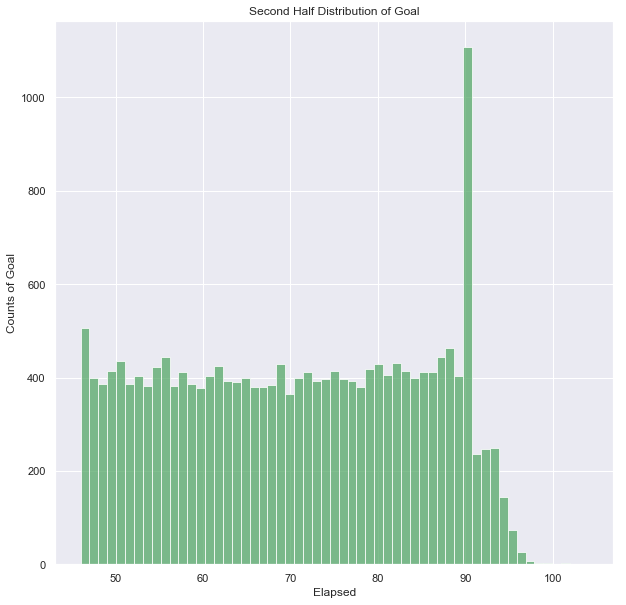

In [34]:
plt.xlabel('Elapsed')
plt.ylabel('Counts of Goal')
plt.title('Second Half Distribution of Goal')
plt.hist(df2_secondhalf.time, secondhalf_bin, facecolor='g', alpha=0.75);

***
## Conclusions

### 1. I have 35090 goal records, the counts of goal distribution by elapsed are not normal distribution. 
### 2. The distribution shows that in every minute the event of goal could be occurred. It is even distribution. So when you open the TV sport channel anytime, the goal could occurr, don't worry about missing goal.
### 3. Only significantly different is before the end of each half match, the goal occurred before the end of each half match more than usual. Even so the games are boring, you will have surprise in the end possibly.
***

<a id='Q3'></a>
### Q3: Is there any formation which have victory to another formation in high probability?
***

## Data Wrangling
### 1. The team formations are store in table match
### 2. From Y coordinate could extract team formation
### 3. To sort Y coordinate, and to count how many player are in same Y coordinate, than I can get team formation, like: 442,4231 and so on.
### 4. In each match, we have two team formation, we also know which team win or lose, or they got equalize.
### 5. According to the match result and two team formation, I want to explore answer of my question.
***

In [35]:
#the dataset for question 3:Is there any formation which have victory to another formation in high probability?
rs3 = con.execute('SELECT match_api_id,home_team_goal,away_team_goal,\
                home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,\
                home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,\
                away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,\
                away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11\
                FROM Match')
# get two team goal, 11 players Y coordinate for each team.
df3 = pd.DataFrame(rs3.fetchall())
df3.columns = rs3.keys()

con.close()

In [36]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 25 columns):
match_api_id       25979 non-null int64
home_team_goal     25979 non-null int64
away_team_goal     25979 non-null int64
home_player_Y1     24158 non-null float64
home_player_Y2     24158 non-null float64
home_player_Y3     24147 non-null float64
home_player_Y4     24147 non-null float64
home_player_Y5     24147 non-null float64
home_player_Y6     24147 non-null float64
home_player_Y7     24147 non-null float64
home_player_Y8     24147 non-null float64
home_player_Y9     24147 non-null float64
home_player_Y10    24147 non-null float64
home_player_Y11    24147 non-null float64
away_player_Y1     24147 non-null float64
away_player_Y2     24147 non-null float64
away_player_Y3     24147 non-null float64
away_player_Y4     24147 non-null float64
away_player_Y5     24147 non-null float64
away_player_Y6     24147 non-null float64
away_player_Y7     24147 non-null float64
away_player_Y8 

In [37]:
df3.dropna(inplace=True)
# drop the null row, because there are not whole formation

In [38]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24140 entries, 144 to 25978
Data columns (total 25 columns):
match_api_id       24140 non-null int64
home_team_goal     24140 non-null int64
away_team_goal     24140 non-null int64
home_player_Y1     24140 non-null float64
home_player_Y2     24140 non-null float64
home_player_Y3     24140 non-null float64
home_player_Y4     24140 non-null float64
home_player_Y5     24140 non-null float64
home_player_Y6     24140 non-null float64
home_player_Y7     24140 non-null float64
home_player_Y8     24140 non-null float64
home_player_Y9     24140 non-null float64
home_player_Y10    24140 non-null float64
home_player_Y11    24140 non-null float64
away_player_Y1     24140 non-null float64
away_player_Y2     24140 non-null float64
away_player_Y3     24140 non-null float64
away_player_Y4     24140 non-null float64
away_player_Y5     24140 non-null float64
away_player_Y6     24140 non-null float64
away_player_Y7     24140 non-null float64
away_player_Y

In [39]:
df3.head()

,match_api_id,home_team_goal,away_team_goal,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,...,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11
144,493016,1,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0
145,493017,2,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0
146,493018,3,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0
147,493019,4,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0
148,493020,0,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0


In [40]:
home_formation = {}
away_formation = {}
#create two dict to store home team formation and away team formation, key is match_api_id, value is formation like '442'

In [41]:
#every row is a match, extract formation according to Y coordinates
for index,row in df3.iterrows():
    home_player_y = list()
    away_player_y = list()
    #create two list to store Y coordinate for each team,and they should be empty when we start parse a new match
    
    for i in range(2,12):
        home_player_y.append(row['home_player_Y%d' % i])
        away_player_y.append(row['away_player_Y%d' % i])
    #put two teams's Y coordinates into lists, I will ignore Y1 plyaer, because Y1 always is goalkeeper, he is position are fixed
    
    c_home = Counter(home_player_y)
    c_away = Counter(away_player_y)
    #transform list to Counter objects
    formation_home = Counter(sorted(c_home.elements())).values()
    #sorted,for exsample: Y coordinate may be record with wrong, like "5,5,3,3,3,3,5,7,7,10", the correct formation should be 4321,
    #but if we don't serted it, we will get 3421
    formation_home = OnlyNum(str(formation_home))
    #get only number, like '442', but it is still a string.
    formation_away = Counter(sorted(c_away.elements())).values()
    formation_away = OnlyNum(str(formation_away))
    
    home_formation.update({row['match_api_id'] : formation_home})
    away_formation.update({row['match_api_id'] : formation_away})
    #update match id and formation to dict

In [42]:
df3['home_formation'] = df3['match_api_id'].map(home_formation)
df3['away_formation'] = df3['match_api_id'].map(away_formation)
#map formation to DataFrame following match_api_id

In [43]:
df3.head()

,match_api_id,home_team_goal,away_team_goal,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,...,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_formation,away_formation
144,493016,1,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,442,442
145,493017,2,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,442,442
146,493018,3,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,442,442
147,493019,4,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,442,442
148,493020,0,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,442,442


In [44]:
print(df3.home_formation.unique())
print(df3.away_formation.unique())

['442' '451' '343' '433' '532' '352' '541' '3331' '4141' '3232' '4231'
 '3511' '4321' '4411' '3412' '41212' '4213' '4312' '4132' '5311' '4123'
 '3421' '4222' '41221']
['442' '343' '433' '532' '451' '3331' '541' '352' '4213' '4231' '4411'
 '4141' '4321' '3412' '41212' '4222' '4123' '4312' '4132' '3511' '3421'
 '5311' '31312' '41221' '3232']


In [45]:
set(df3.home_formation.unique())-set(df3.away_formation.unique())
#compare home team and away team formation , the number of home formation is no more than away formation

set()

In [46]:
set(df3.away_formation.unique())-set(df3.home_formation.unique())
#but away formation has one special item formation '31312', lets check it

{'31312'}

In [47]:
df3[df3['away_formation']=='31312']
#that is only one match with equalize 0:0, so I will drop it.

,match_api_id,home_team_goal,away_team_goal,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,...,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_formation,away_formation
4229,1724003,0,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,3.0,5.0,7.0,7.0,7.0,9.0,11.0,11.0,442,31312


In [48]:
index31312 = df3[df3['away_formation']=='31312'].index.get_values()
df3.drop(index31312,inplace=True)

In [49]:
df3.drop(columns=['home_player_Y1','home_player_Y2','home_player_Y3','home_player_Y4','home_player_Y5','home_player_Y6','home_player_Y7','home_player_Y8','home_player_Y9','home_player_Y10','home_player_Y11'],inplace = True)
df3.drop(columns=['away_player_Y1','away_player_Y2','away_player_Y3','away_player_Y4','away_player_Y5','away_player_Y6','away_player_Y7','away_player_Y8','away_player_Y9','away_player_Y10','away_player_Y11'],inplace = True)
# delete Y coordinate, because we'dont need them anymore.

In [50]:
df3.head()

,match_api_id,home_team_goal,away_team_goal,home_formation,away_formation
144,493016,1,1,442,442
145,493017,2,1,442,442
146,493018,3,0,442,442
147,493019,4,0,442,442
148,493020,0,1,442,442


In [51]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24139 entries, 144 to 25978
Data columns (total 5 columns):
match_api_id      24139 non-null int64
home_team_goal    24139 non-null int64
away_team_goal    24139 non-null int64
home_formation    24139 non-null object
away_formation    24139 non-null object
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [52]:
df3['resulte']=df3['home_team_goal']-df3['away_team_goal']
# define resulte as win or lose(for home team)

In [53]:
idx = (df3['resulte']<0)
# select the index of the match which home team losed

df3.loc[idx,['home_formation','away_formation']] = df3.loc[idx,['away_formation','home_formation']].values
df3.loc[idx,['home_team_goal','away_team_goal']] = df3.loc[idx,['away_team_goal','home_team_goal']].values
#switch home team and away team columns, than columns 'home_team_goal' is 'win team goal' same as formation
#so we will change columns names, there are no home and away, there are only 'win','lose'

In [54]:
df3.rename(columns = {'home_team_goal':'win_team_goal',\
                     'away_team_goal':'lose_team_goal',\
                     'home_formation':'win_formation',\
                     'away_formation':'lose_formation'},inplace=True)
#acoording to switch, we need to change the columns name, there are no more 'home team'and 'away team', only win team and lose team.

In [55]:
df3['resulte']=df3['win_team_goal']-df3['lose_team_goal']
#re calculate columns 'resulte',make sure the value are greater or equal 0

In [56]:
df3.head()

,match_api_id,win_team_goal,lose_team_goal,win_formation,lose_formation,resulte
144,493016,1,1,442,442,0
145,493017,2,1,442,442,1
146,493018,3,0,442,442,3
147,493019,4,0,442,442,4
148,493020,1,0,442,442,1


In [57]:
dd = df3['match_api_id'].groupby([df3['win_formation'],df3['lose_formation']]).count()
#groupby win formatin and lose formation count number of matchs
formation_match_df = dd.unstack()
formation_match_df = formation_match_df.fillna(0)
formation_match_df.astype('int64')
# we got a dataframe include diffrent formation match between each other
#this dataframe is only for observed the data,and check the groupby method, it is not for use furter.
#next step, I will separate equalize an no-equalize match to check the data.

lose_formation,3232,3331,3412,3421,343,3511,352,41212,41221,4123,...,4231,4312,4321,433,4411,442,451,5311,532,541
win_formation,,,,,,,,,,,,,,,,,,,,,
3232,1,0,0,0,2,0,0,0,2,0,...,4,1,1,0,0,3,0,0,0,0
3331,0,0,0,0,0,0,1,1,0,0,...,1,0,0,1,0,2,0,0,1,2
3412,0,0,9,7,4,4,16,1,0,1,...,28,7,1,24,6,14,3,0,1,0
3421,0,0,9,10,4,6,24,3,0,1,...,34,22,6,15,5,20,1,0,6,2
343,1,0,3,5,20,4,34,8,0,1,...,44,16,5,37,18,54,20,0,10,6
3511,0,0,2,2,1,4,25,5,0,0,...,13,7,5,25,3,15,3,0,3,0
352,0,0,10,29,12,38,117,21,0,1,...,73,49,11,107,23,113,37,0,25,10
41212,1,1,3,6,4,4,16,63,10,7,...,182,6,14,65,14,59,6,0,12,6
41221,0,0,0,0,0,0,0,20,105,1,...,182,0,0,1,0,5,0,0,4,4


In [58]:
df3_equalize = df3.loc[df3['resulte']==0]
df3_noequalize = df3.loc[df3['resulte']!=0]
#now I saperate equalize match and no equalize to two dataframe

In [59]:
dd_equalize = df3_equalize['match_api_id'].groupby([df3_equalize['win_formation'],df3_equalize['lose_formation']]).count()
formation_match_equalize = dd_equalize.unstack()
# I found there is one formation is missing on columns which name is '5311', I insert a null column, and set a #21 column
# that is for data organized 
formation_match_equalize.insert(21,'5311',np.nan)

formation_match_equalize = formation_match_equalize.fillna(0)
formation_match_equalize.astype('int64')
#fill NaN to zero, and set all number to int

lose_formation,3232,3331,3412,3421,343,3511,352,41212,41221,4123,...,4231,4312,4321,433,4411,442,451,5311,532,541
win_formation,,,,,,,,,,,,,,,,,,,,,
3232,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3412,0,0,3,2,2,2,4,0,0,1,...,6,2,0,5,1,6,1,0,0,0
3421,0,0,2,3,1,3,10,0,0,0,...,7,6,0,3,0,4,1,0,0,0
343,1,0,2,1,6,2,8,5,0,1,...,11,4,1,8,7,18,5,0,5,1
3511,0,0,1,1,0,0,6,2,0,0,...,5,1,1,11,1,4,0,0,3,0
352,0,0,2,11,2,8,29,6,0,1,...,16,16,3,31,5,28,13,0,6,4
41212,1,0,1,4,2,2,3,18,3,3,...,58,1,4,21,3,15,0,0,2,1
41221,0,0,0,0,0,0,0,3,31,1,...,55,0,0,0,0,1,0,0,2,1


In [60]:
dd_noequalize = df3_noequalize['match_api_id'].groupby([df3_noequalize['win_formation'],df3_noequalize['lose_formation']]).count()
formation_match_noequalize = dd_noequalize.unstack()

formation_match_noequalize = formation_match_noequalize.fillna(0)
formation_match_noequalize.astype('int64')
#do same thing with equalize match , but here we dont need to add columns

lose_formation,3232,3331,3412,3421,343,3511,352,41212,41221,4123,...,4231,4312,4321,433,4411,442,451,5311,532,541
win_formation,,,,,,,,,,,,,,,,,,,,,
3232,1,0,0,0,2,0,0,0,2,0,...,3,0,1,0,0,3,0,0,0,0
3331,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,2,0,0,0,2
3412,0,0,6,5,2,2,12,1,0,0,...,22,5,1,19,5,8,2,0,1,0
3421,0,0,7,7,3,3,14,3,0,1,...,27,16,6,12,5,16,0,0,6,2
343,0,0,1,4,14,2,26,3,0,0,...,33,12,4,29,11,36,15,0,5,5
3511,0,0,1,1,1,4,19,3,0,0,...,8,6,4,14,2,11,3,0,0,0
352,0,0,8,18,10,30,88,15,0,0,...,57,33,8,76,18,85,24,0,19,6
41212,0,1,2,2,2,2,13,45,7,4,...,124,5,10,44,11,44,6,0,10,5
41221,0,0,0,0,0,0,0,17,74,0,...,127,0,0,1,0,4,0,0,2,3


In [61]:
#now we create a statistic dataframe, to calculate A - B win p value
df_statistic=pd.DataFrame(columns =\
                      ['A formation',\
                       'B formation',\
                       'Total Number match',\
                       'Num A win',\
                       'Num Equalize',\
                       'Num B win',\
                       'Z score A win',\
                       'P value A win',\
                       'Z score B win',\
                       'P value B win',\
                       ])
# 'Total Number match' -bettween two formation, total number of match during 2008-2016
# 'Num A win',  --------how many matchs that A formation win
# 'Num Equalize',-------how many matchs that A and B get equalize
# 'Num B win'  ---------how many matchs that B formation win
# 'Z score A win',------hypothesis test: Ho: formations A and B are no diffrent, the probability of A win is 50%,P = Po=0.5
#  'P value A win',-----Ha: formation A is more aggressivity when A meet B, the probability of A win is more than 50%, P>Po
# 'Z score B win',------another hypothesis test, Ho is same with above
# 'P value B win',------Ha: formation B is more aggressivity when B meet A.
#df_stats will give us statistc resulte, each row represanted a combination of two formation.
# we have 24 formations, I dont count combination of same formation, than total combinations will be 23+22+21+....+3+2+1 = 276,
#following are the code:
#x = 0
#for i in range(1,24):
#    x += i
#print(x)

In [62]:
df_statistic

,A formation,B formation,Total Number match,Num A win,Num Equalize,Num B win,Z score A win,P value A win,Z score B win,P value B win


In [63]:
same_formation = 0
#same_formation is store the number of match bettween same formation, for double check if I do some missing.

#this for loop, set value to df_stats from previous dataframes
for i in formation_match_noequalize.index:
    for j in formation_match_noequalize.columns:
        if i == j:
            same_formation += formation_match_noequalize.loc[i,j]
            same_formation += formation_match_equalize.loc[i,j]
            break
            #break here, we just get number form under diagonal,and diagonal is match bettween same formation
        else:
            df_statistic = df_statistic.append({\
                                        'A formation':i,\
                                        'B formation':j,\
                                        'Num A win':formation_match_noequalize.loc[i,j],\
                                        #A win B number of match
                                        'Num Equalize':formation_match_equalize.loc[i,j]+formation_match_equalize.loc[j,i],\
                                        #A to B and B to A are symmetric diagonally, I count both.
                                        'Num B win':formation_match_noequalize.loc[j,i]\
                                        #B win A number of match,symmetric diagonally
                                        },ignore_index=True)


In [64]:
df_statistic

,A formation,B formation,Total Number match,Num A win,Num Equalize,Num B win,Z score A win,P value A win,Z score B win,P value B win
0,3331,3232,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,3412,3232,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3412,3331,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,3421,3232,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,3421,3331,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,3421,3412,NaN,7.0,4.0,5.0,NaN,NaN,NaN,NaN
6,343,3232,NaN,0.0,1.0,2.0,NaN,NaN,NaN,NaN
7,343,3331,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,343,3412,NaN,1.0,4.0,2.0,NaN,NaN,NaN,NaN
9,343,3421,NaN,4.0,2.0,3.0,NaN,NaN,NaN,NaN


In [65]:
df_statistic['Total Number match'] = df_statistic['Num A win'] + df_statistic['Num B win'] + df_statistic['Num Equalize']

In [66]:
print(df_statistic['Total Number match'].sum())
print(same_formation)
# I need to check if all match number are missing, total number should be 24139

14377.0
9762.0


***
## Exploratory Data Analysis
### 1. Now I will calculate z score and p value
### 2. Null hypothesis Ho: The victory between two team formation are same, no different. 
### 3. Ha: The team formation A(or B) has high probability to win team formation B( or A)
### 4. Po = 0.5, that means both formation have same probability to win.
### 5. n is sample size,when n * Po >=10, n * (1-Po)>=10, we can use z test to calculate p value, so n must be greater than 20.
### 6. When p value <= 0.05, we have enough evidence to reject Ho.
***

In [67]:
z_score_awin = {}
p_value_awin = {}
z_score_bwin = {}
p_value_bwin = {}
#
for index,row in df_statistic.iterrows():
    if row['Total Number match']>=20 : 
        # if we want to make statastic, the number of sample n should satisfy the conditions 
        #which allow you to use this test, the conditions is: n*Po >=10 and n*(1-Po)>=10. we know Po = 0.5, which is mean 
        #each formation in a match has same probability to win, so Po=0.5. According to Po, we can calculate n >=20 .
        #so I consider formation match which are more than 20 times only.
        count_awin = int(row['Num A win'])+int(row['Num Equalize']/2)  #A win plus half equalize number
        #count_awin = int(row['Num A win'])
        count_bwin = int(row['Num B win'])+int(row['Num Equalize']/2)  #B win plus half equalize number
        #count_bwin = int(row['Num B win'])
        nobs = int(row['Total Number match'])                          #sample number is total match number bettween two formation
        value = 0.5                                                    # Po=0.5
        z_awin,p_awin = proportions_ztest(count_awin,nobs,0.5,alternative='larger')
        z_bwin,p_bwin = proportions_ztest(count_bwin,nobs,0.5,alternative='larger')
        z_score_awin.update({index:z_awin})                            #z score z = (p-Po)/sqrt(Po*(1-Po)/n)
        p_value_awin.update({index:p_awin})
        z_score_bwin.update({index:z_bwin})
        p_value_bwin.update({index:p_bwin})

In [68]:
df_statistic['Z score A win'] = df_statistic.index.map(z_score_awin)
df_statistic['P value A win'] = df_statistic.index.map(p_value_awin)
df_statistic['Z score B win'] = df_statistic.index.map(z_score_bwin)
df_statistic['P value B win'] = df_statistic.index.map(p_value_bwin)

In [69]:
df_statistic

,A formation,B formation,Total Number match,Num A win,Num Equalize,Num B win,Z score A win,P value A win,Z score B win,P value B win
0,3331,3232,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,3412,3232,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3412,3331,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,3421,3232,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,3421,3331,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,3421,3412,16.0,7.0,4.0,5.0,NaN,NaN,NaN,NaN
6,343,3232,3.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN
7,343,3331,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,343,3412,7.0,1.0,4.0,2.0,NaN,NaN,NaN,NaN
9,343,3421,9.0,4.0,2.0,3.0,NaN,NaN,NaN,NaN


In [70]:
df_a_win = df_statistic.loc[df_statistic['P value A win']<=0.05]  # if p value is smaller than 0.05, we have enough evidence 
df_b_win = df_statistic.loc[df_statistic['P value B win']<=0.05]  #to reject Null Hypothesis, there is a significance of the results

In [71]:
df_a_win  # A formation has significance probability to win B formation

,A formation,B formation,Total Number match,Num A win,Num Equalize,Num B win,Z score A win,P value A win,Z score B win,P value B win
35,41221,41212,30.0,17.0,6.0,7.0,1.936492,0.026404,-1.936492,0.973596
102,4231,4141,547.0,242.0,139.0,166.0,3.237343,0.000603,-3.325394,0.999559
111,4312,352,115.0,54.0,28.0,33.0,1.991750,0.023199,-1.991750,0.976801
119,4312,4231,191.0,80.0,55.0,56.0,1.676421,0.046828,-1.824634,0.965972
143,433,41212,160.0,74.0,42.0,44.0,2.414531,0.007878,-2.414531,0.992122
147,433,4141,137.0,73.0,29.0,35.0,3.283125,0.000513,-3.475806,0.999745
150,433,4231,1755.0,758.0,416.0,581.0,4.246731,0.000011,-4.246731,0.999989
182,442,4141,258.0,125.0,60.0,73.0,3.305208,0.000475,-3.305208,0.999525
185,442,4231,1615.0,644.0,394.0,577.0,1.668640,0.047594,-1.668640,0.952406
187,442,4321,76.0,40.0,17.0,19.0,2.377974,0.008704,-2.636450,0.995811


In [72]:
df_b_win  # B formation has significance probability to win A formation

,A formation,B formation,Total Number match,Num A win,Num Equalize,Num B win,Z score A win,P value A win,Z score B win,P value B win
19,352,343,46.0,10.0,10.0,26.0,-2.516184,0.994068,2.516184,0.005932
167,4411,4231,329.0,85.0,99.0,145.0,-3.422379,0.999690,3.306376,0.000473
170,4411,433,183.0,49.0,40.0,94.0,-3.431872,0.999700,3.431872,0.000300
204,451,4231,119.0,26.0,26.0,67.0,-4.003594,0.999969,4.003594,0.000031
207,451,433,265.0,68.0,66.0,131.0,-3.984289,0.999966,3.984289,0.000034
208,451,4411,81.0,18.0,19.0,44.0,-3.181981,0.999269,2.920354,0.001748
209,451,442,821.0,243.0,224.0,354.0,-3.909826,0.999954,3.909826,0.000046
245,532,4231,63.0,13.0,12.0,38.0,-3.431446,0.999700,3.431446,0.000300
248,532,433,75.0,17.0,20.0,38.0,-2.525907,0.994230,2.525907,0.005770
267,541,4231,58.0,13.0,12.0,33.0,-2.797724,0.997427,2.797724,0.002573


***
## Conclusions
### That is good time to share my conclusions. There are 21 combination of formation, when the two formation meet in a match, we could say which one have more chance to win.
### 1. 41221,4231,4312,433,442,343,4411 are present to win formation
### 2. But that is not mean those formation have Absolute odds.
### 3. For example 4231 can win 5 other formation, but when 4231 meet 433 or 442, it has no odds.
### 4. So if you are a soccer coach, and if you know opponent formation, that is a good Reference comments.
***

In [73]:
print("You need %s seconds to run all script" % (time.time() - start_time))

You need 88.83124947547913 seconds to run all script
